# Student side

Our "student" (a learning service) wishes to be trained in recognizing MNIST images, and is ready to pay up to 1000 DOPA wei tokens if it achieves 100% accuracy. The student requires every teacher to pay 20 DOPA weis to teach it, and plans to charge 10 DOPA weis for every classification it later makes.

## About MNIST
[MNIST](href='https://en.wikipedia.org/wiki/MNIST_database') is a large database of handwritten digits that is commonly used for training various image processing systems. Below are the first 8 test figures in this database:

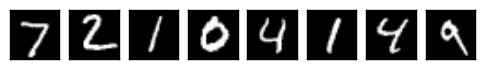

In [1]:
import matplotlib.pyplot as plt
from mnist import MnistData
mnist_data = MnistData(0,0)

def plot_mnist(n):
    fig = plt.figure(1)
    subplot_num = 180
    for i in range(n):
        subplot_num += 1
        plt.subplot(subplot_num)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mnist_data.x_test[i].reshape([28,28]), cmap='gray')
    plt.show()
plot_mnist(8)

## About Teacher Reward Calculators

In this sample we used a <I> LogarithmicTeacherReward </I> calculator (available in the Dopamine library), which means that the teachers are rewarded on a logarithmic scale according to their contributions to raising the student's score. In this example, if we get to 100%, the teacher/s that helped bring the student's score from 99% to 100% get half of the total reward (500 tokens). The code below plots the cumulative reward per achieved score:

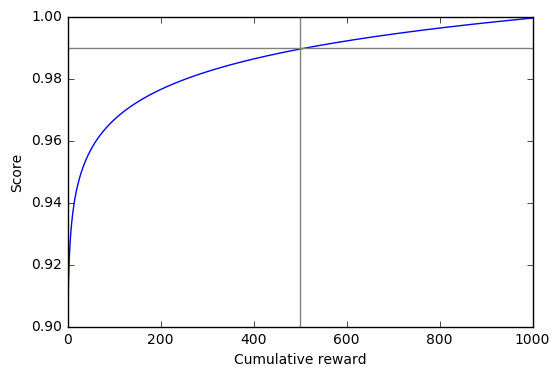

In [2]:
from dopapy.utils.calculators.reward.teacher import LogarithmicTeacherReward
ltr = LogarithmicTeacherReward(min_score=0.0, mid_score=0.99, max_score=1.0, reward_sum=1000)
x = []
y = []
bins = 1000
cumulative_reward = 0
for i in range(0,bins,1):
    from_score = 1.0/bins*i
    to_score = from_score+1.0/bins
    cumulative_reward += ltr.get_reward(from_score,to_score)
    y += [cumulative_reward]
    x += [(from_score+to_score)*0.5]
plt.figure()
plt.plot(y, x)
plt.xlim((0,1000))
plt.ylim((0.9,1.0))
plt.axvline(x=500, color='grey')
plt.axhline(y=0.99, color='grey')
plt.xlabel('Cumulative reward')
plt.ylabel('Score')
plt.show()

## Our Student

Our "student" is a learning service based on labels, which means it needs to derive Dopamine's LabeledLearningServiceInstanceBase class and implement some abstract methods. Basically, the code below does that while wrapping the Deep Learning model which is coded in [DigitClassifier](digit_classifier.py):

In [3]:
from digit_classifier import DigitClassifier
from dopapy.core.services.instance.base.learning import LabeledLearningServiceInstanceBase


class Student(LabeledLearningServiceInstanceBase):
    def __init__(self):
        super().__init__()
        self.digit_classifier = DigitClassifier()
        self.digit_classifier.build_graph()
        self.reward_calculator = ltr
        self.rewards_given=[]
        self.score_reached=[]
        self.total_rewards_given=0
        
    def train(self, update, return_gradient, data, labels):
        if return_gradient:
            raise InvalidArgumentException('return_gradient not supported')
        elif not update:
            raise InvalidArgumentException('not updating not supported')
        else:
            x_train, y_train = data[0], labels[0]
            print('Starting a training session...')
            score_before, score_after = self.digit_classifier.train_and_return_accuracy_change(x_train.data, y_train.data)        
            print('Score_before: {0}, score_after:{1}'.format(score_before[1], score_after[1]))
            reward = int(self.reward_calculator.get_reward(from_score=score_before[1], to_score=score_after[1]))
            print('Reward:',reward)
            context=next (iter (quote.get_context_data_collection()[dt.ServiceDescriptor.DEFAULT_SERVICE_INSTANCE_ID].values()))
            destination_account=context.counter_account_address
            print('destination_account:',destination_account)
            session.send_dopamine(amount=reward,destination_account=destination_account,min_gas_price=1000)
            print('Reward sent:{0}'.format(reward))
            self.total_rewards_given=self.total_rewards_given+reward
            self.rewards_given+=[self.total_rewards_given]
            self.score_reached+=[score_after[1]]
            return y_train

    def predict(self, data):
        return dd.Tensor(self.digit_classifier.predict(data.data))

    def save_in_file(self, file_name):
        self.digit_classifier.save_in_file(file_name)

    def load_from_file(self, file_name):
        self.digit_classifier.load_from_file(file_name)


## Student Instance Creators

In our example all teachers are training <B><U> the same </B></U> student, which is demonstrated in the following class. In future examples we will show use cases where every client works with it's own instance:

In [4]:
import dopapy
import dopapy.trading as dp
import dopapy.types as dt
from dopapy.utils.common.guid import GUID
from dopapy.core.services.instance.iservice import IServiceInstance, ILabeledLearningServiceInstance
from dopapy.core.services.instance.creator.icreator import IServiceInstanceCreator

class StudentInstanceCreator(IServiceInstanceCreator):
    def __init__(self):
        self.shared_instance = Student()
    def create_instance(self, service_instance_id: GUID):
        if service_instance_id == dt.ServiceDescriptor.DEFAULT_SERVICE_INSTANCE_ID:
            return self.shared_instance
        else:
            raise InvalidArgumentException("This service does not support unique (non zero) instances")

# Plugging the Student onto the Dopamine Network

In [5]:
dopapy.init_logging()
import warnings
warnings.filterwarnings('ignore') #Thats just to ignore warnings that are irrelevant for this type of sample

session = dp.create_session(master_password='password123456',
                            keystore_dir='/data/dopamine/keystore_dir_b/',
                            web_server_host="127.0.0.1",
                            dopmn_budget=10000,  # Allow to spend DOPAs from this account
                            ether_budget=int(10E18),
                            web_server_port=8007)

my_service_descriptor = dt.ServiceDescriptor(
    service_role=dt.ServiceRole.PROVIDER,
    input_descriptors=[dt.TensorDescriptor([-1,28,28,1])],
    output_descriptors=[dt.TensorDescriptor([-1])],
    service_type=dt.ServiceType.Learning.LABELED
)

student_reward_desc = dp.create_reward_descriptor(min_dopamine_price=10)
student_reward_desc.add_payment(dt.RewardPaymentType.UPDATE, min_price=20)
student_reward_desc.add_payment(dt.RewardPaymentType.FORWARD, min_price=0)

my_student_instance_creator = StudentInstanceCreator()
quote = dp.create_quote_services(
    service_instance_creator = my_student_instance_creator,
    session=session,
    service_descriptor=my_service_descriptor,
    side=dp.SELL,
    reward_descriptor=student_reward_desc)

quote.publish()

Right before school starts, we expect the student to be quite unintelligent, since no teacher has started teaching it yet:

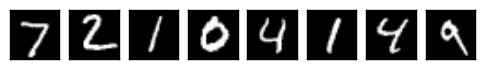

read numbers: [4 6 6 7 4 6 7 6]


In [6]:
import numpy as np
student = my_student_instance_creator.shared_instance
plot_mnist(8)
print("read numbers:", student.digit_classifier.predict_classes(mnist_data.x_test[0:8]))

### Here student needs to wait for the teachers to do their work...

<img src='../img/waiting.png'>

### Checking balance before teaching:

In [7]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000004657
ETH  Balance: 8898051600000000000
Starting a training session...
Score_before: 0.1014, score_after:0.9572
Reward: 48
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:48
Starting a training session...
Score_before: 0.9572, score_after:0.9792
Reward: 185
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:185
Starting a training session...
Score_before: 0.9792, score_after:0.9836
Reward: 85
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:85
Starting a training session...
Score_before: 0.9836, score_after:0.9842
Reward: 13
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:13
Starting a training session...
Score_before: 0.9842, score_after:0.9842
Reward: 0
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:0


## Analyzing the teaching process

### Checking balance after teaching:

In [8]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000004426
ETH  Balance: 8824595200000000000


### Testing the student
We can test now our student and see whether it became any smarter:

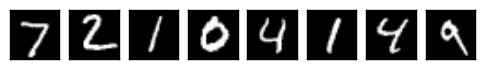

read numbers: [7 2 1 0 4 1 4 9]


In [9]:
plot_mnist(8)
print("read numbers:", student.digit_classifier.predict_classes(mnist_data.x_test[0:8]))

### Contribution vs Reward per Teacher

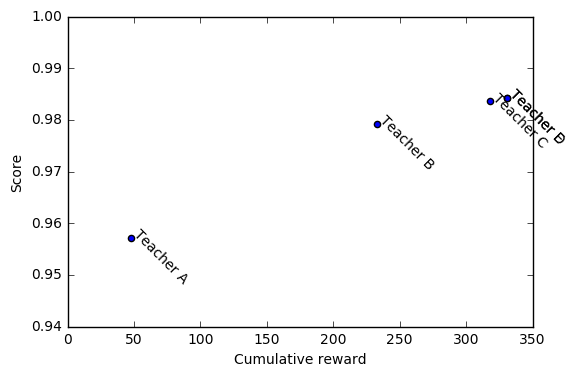

In [10]:
names = ['Teacher A','Teacher B','Teacher C','Teacher D','Teacher E']        
plt.figure()
fig, ax = plt.subplots()
ax.scatter(student.rewards_given, student.score_reached)
plt.xlabel('Cumulative reward')
plt.ylabel('Score')
for i, txt in enumerate(names):
    ax.annotate(txt, (student.rewards_given[i],student.score_reached[i]), rotation=-45)
plt.show()  

Above, the chart shows that eventually the student got to accuracy of 0.9842. The last teacher did not improve it's capabilities and did not get rewarded. And that the most rewarded teacher was teacher "B" that was the first teacher using 20K samples (see [teachers.ipynb](teachers.ipynb)).